In [1]:
# Grafico de la ganancia que visualiza el overfitting
# La idea es probar con distintos hiperparametros del arbol de decision
# y ver como se acercan o separan las curvas de ganancia
# MUY importante :  notar que Training = 50%  y  Testing = 50%

# Notar que la curva en training es siempre convexa
# mientras que la de testing puede tener concavidades

In [2]:
rm(list = ls()) # Borro todos los objetos
gc() # Garbage Collection

# cargo las librerias que necesito
require("data.table")
require("rpart")
require("ggplot2")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,632935,33.9,1409332,75.3,1376779,73.6
Vcells,1173276,9.0,8388608,64.0,1815614,13.9


Loading required package: data.table

Loading required package: rpart

Loading required package: ggplot2



In [3]:
# cambiar aqui los parametros
PARAM <- list()
PARAM$minsplit <- 800
PARAM$minbucket <- 250
PARAM$maxdepth <- 8

#------------------------------------------------------------------------------

In [4]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa = "", campo = "fold",
                        start = 1, seed = NA) {
       if (!is.na(seed)) set.seed(seed)

       bloque <- unlist(mapply(
              function(x, y) {
                     rep(y, x)
              },
              division, seq(from = start, length.out = length(division))
       ))

       data[, (campo) := sample(rep(
              bloque,
              ceiling(.N / length(bloque))
       ))[1:.N],
       by = agrupa
       ]
}

#------------------------------------------------------------------------------
#------------------------------------------------------------------------------

In [5]:
# Aqui empieza el programa

setwd("~/buckets/b1/") # Establezco el Working Directory


In [6]:
#cargo MI amada primera semilla, que esta en MI bucket
tabla_semillas <- fread( "./datasets//mis_semillas.txt" )
ksemilla_azar <- tabla_semillas[ 1, semilla ]  # 1 es mi primera semilla

In [7]:
# cargo el dataset
dataset <- fread("./datasets/dataset_pequeno.csv")

# a partir de ahora solo trabajo con 202107, el mes que tiene clase
dataset <- dataset[foto_mes == 202107] # defino donde voy a entrenar

In [8]:
# La division training/testing es 50%, 50%
#  que sea 50/50 se indica con el c(1,1)
particionar(dataset,
       division = c(1, 1),
       agrupa = "clase_ternaria", seed = ksemilla_azar
)

In [9]:
# Entreno el modelo
# los datos donde voy a entrenar
# aqui es donde se deben probar distintos hiperparametros
modelo <- rpart(
       formula = "clase_ternaria ~ . -fold",
       data = dataset[fold == 1, ],
       xval = 0,
       cp = -1,
       minsplit = PARAM$minsplit,
       minbucket = PARAM$minbucket,
       maxdepth = PARAM$maxdepth
)


In [10]:
# aplico el modelo a TODOS los datos, inclusive los de training
prediccion <- predict(modelo, dataset, type = "prob")

In [11]:
# Pego la probabilidad de  BAJA+2
dataset[, prob_baja2 := prediccion[, "BAJA+2"]]

In [12]:
# Dibujo la curva de ganancia acumulada
setorder(dataset, fold, -prob_baja2)

In [13]:
# agrego una columna que es la de las ganancias
# la multiplico por 2 para que ya este normalizada
#  es 2 porque cada fold es el 50%
dataset[, gan := 2 *ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
dataset[, ganancia_acumulada := cumsum(gan), by = fold]
dataset[, pos := sequence(.N), by = fold]

Train gan max:  56430000 
Test  gan max:  50964000 


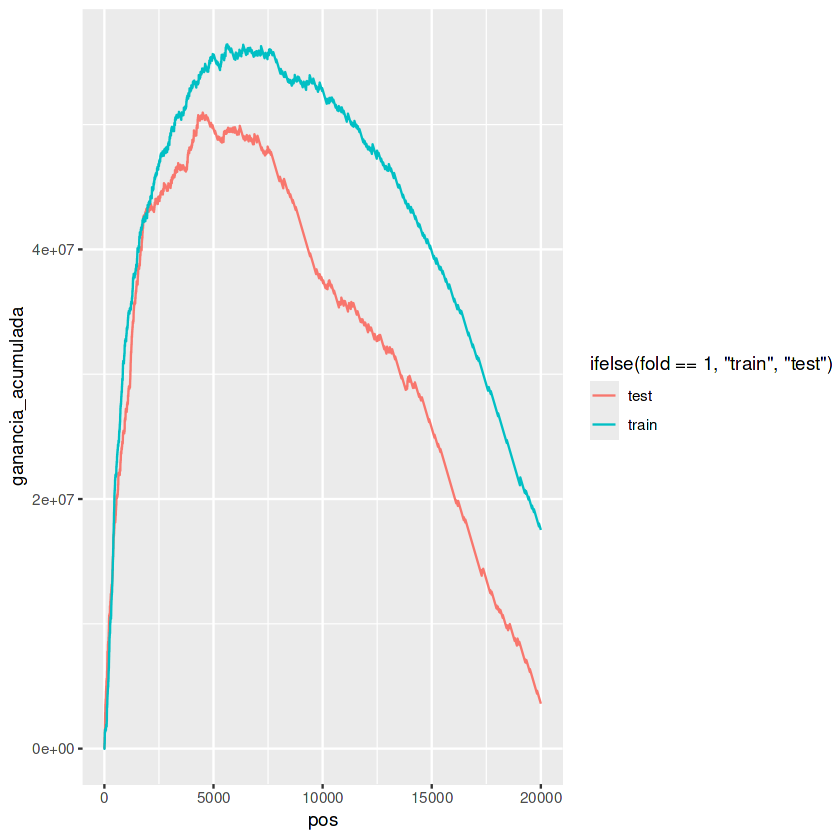

In [14]:
# Esta hermosa curva muestra como en el mentiroso training
#   la ganancia es siempre mejor que en el real testing
# segundo grafico solo los primeros 20k enviso
gra <- ggplot(
           data = dataset[pos <= 20000],
           aes( x = pos, y = ganancia_acumulada,
                color = ifelse(fold == 1, "train", "test") )
             ) + geom_line()

print( gra )

cat( "Train gan max: ", dataset[fold==1, max(ganancia_acumulada)], "\n" )
cat( "Test  gan max: ", dataset[fold==2, max(ganancia_acumulada)], "\n" )
